In [16]:
#Importation needed 
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import os 
import glob
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Masking , Bidirectional, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from src.helpers_death_regression import*

**Data loading**

In [17]:
SEGMENT_LENGTH = 900 
FEATURE_COLS = ['X', 'Y', 'Speed', 'turning_angle']  
FEATURE_COLS_MAPPING = {
    'X': 0, 
    'Y': 1, 
    'Speed': 2, 
    'turning_angle': 3 
}
DEBUG = False  # allow or not some print 
try:
    data_result = load_data_death_regressor(
        data_dir=os.getcwd(),
        segments_subdir="preprocessed_data/segments",
        lifespan_file="TERBINAFINE/lifespan_summary.csv",
        segment_length=SEGMENT_LENGTH,
        feature_cols=FEATURE_COLS,
        debug_mode=DEBUG
)
    # Access the loaded segments:
    all_segments = data_result['segments']
except SystemExit:
     print("Data loading terminated due to critical error.")

Loaded 104 lifespan entries. Example keys: ['20240924_piworm09_1', '20240924_piworm09_2', '20240924_piworm09_3', '20240924_piworm09_4', '20240924_piworm09_5']
------------------------------------------------------------


KeyboardInterrupt: 

**Data Split Strategy: Worm-Level Separation**

In [ ]:
# ============================================================
# WORM-LEVEL SPLIT
# Grouping segments by 'worm_id' ensures that all data from a single
# organism remains within the same set (train/val/test).
# ============================================================
worm_to_segments = defaultdict(list)
for seg in all_segments:
    worm_to_segments[seg['worm_id']].append(seg)

all_worm_ids = list(worm_to_segments.keys())

# Splitting the organism IDs
train_worms, temp_worms = train_test_split(
    all_worm_ids, test_size=0.3, random_state=42
)
val_worms, test_worms   = train_test_split(
    temp_worms, test_size=0.5, random_state=42
)

# Displaying the count of Worm IDs
print("\n--- Worm ID Distribution ---")
print(f"Number of worms used for training: {len(train_worms)}")
print(f"Number of worms used for validation: {len(val_worms)}")
print(f"Number of worms used for testing: {len(test_worms)}")

# --- Segment Extraction Function ---
def get_segments_from_worms(worm_list):
    """Retrieves the list of segments corresponding to the provided Worm IDs."""
    return [
        seg for w_id in worm_list
        for seg in worm_to_segments[w_id]
    ]
# Creating the final segment datasets
train_segments = get_segments_from_worms(train_worms)
val_segments   = get_segments_from_worms(val_worms)
test_segments  = get_segments_from_worms(test_worms)
# Displaying the segment count
print("\n--- Total Segment Distribution ---")
print(f"Train segments: {len(train_segments)}")
print(f"Val segments  : {len(val_segments)}")
print(f"Test segments : {len(test_segments)}")


--- Worm ID Distribution ---
Number of worms used for training: 72
Number of worms used for validation: 16
Number of worms used for testing: 16

--- Total Segment Distribution ---
Train segments: 5670
Val segments  : 1362
Test segments : 1118


In [ ]:
FEATURES_TO_USE = ['Speed', 'turning_angle']
X_train, y_train, mask_train = prepare_X_y(
    segments=train_segments, 
    feature_names=FEATURES_TO_USE, 
    feature_mapping=FEATURE_COLS_MAPPING
)
X_val, y_val, mask_val = prepare_X_y(
    segments=val_segments, 
    feature_names=FEATURES_TO_USE, 
    feature_mapping=FEATURE_COLS_MAPPING
)
X_test, y_test, mask_test = prepare_X_y(
    segments=test_segments,
    feature_names=FEATURES_TO_USE, 
    feature_mapping=FEATURE_COLS_MAPPING
)

print(f"Features used: {FEATURES_TO_USE}")
print("Train shapes (X, y, mask):", X_train.shape, y_train.shape, mask_train.shape)
print("Validation shapes (X, y, mask):", X_val.shape, y_val.shape, mask_val.shape)
print("Test shapes (X, y, mask):", X_test.shape, y_test.shape, mask_test.shape)


Features used: ['Speed', 'turning_angle']
Train shapes (X, y, mask): (5670, 900, 2) (5670,) (5670, 900)
Validation shapes (X, y, mask): (1362, 900, 2) (1362,) (1362, 900)
Test shapes (X, y, mask): (1118, 900, 2) (1118,) (1118, 900)


*Test Model with 3 LAYER BI-LSTM*

In [ ]:
# --- Tuned Hyperparameters ---
LSTM_UNITS = 256
REGULARIZER = regularizers.l2(0.0001)
INITIAL_LEARNING_RATE = 0.0001 
BATCH_SIZE = 64
mask_value = 0.0 


# --- EVOLVED 3-LAYER BI-LSTM MODEL ---
model_evolved = Sequential([
    # 1. Masking Layer
    # Skips time steps where all feature values are 'mask_value' (0.0), 
    Masking(mask_value=mask_value, input_shape=(X_train.shape[1], X_train.shape[2])),
    
    # 2. First Bi-LSTM Layer
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS, return_sequences=True, kernel_regularizer=REGULARIZER)
    ),
    
    Dropout(0.2),
    
    # 3. Second Bi-LSTM Layer
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS, return_sequences=True, kernel_regularizer=REGULARIZER)
    ),
    
    Dropout(0.2), 

    # 4. Third Bi-LSTM Layer (Final Recurrent Layer)
    # 'return_sequences=False' extracts only the output state of the last valid time step, 
    # collapsing the time dimension before the Dense layers.
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS // 2, return_sequences=False, kernel_regularizer=REGULARIZER)
    ),
    
    Dropout(0.1),

    # 8. Dense Layers (Feature Processing)
    Dense(64, activation='relu', kernel_regularizer=REGULARIZER),
    Dense(32, activation='relu', kernel_regularizer=REGULARIZER),
    
    # 9. Regression Output
    # Single linear output unit for predicting the continuous target (time-to-death).
    Dense(1,activation='sigmoid') 
])
    
# --- Compilation ---
# Using Adam optimizer and Huber loss, which is less sensitive to outliers than MSE.
model_evolved.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE), 
    loss=tf.keras.losses.Huber(delta=2.0), 
    metrics=['mae']
)

# Callbacks for early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

print(f"Starting training for the 3-layer Bi-LSTM model with T={X_train.shape[1]} timesteps...")

# --- Training ---
history_evolved = model_evolved.fit(
    X_train, y_train,           
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
)
print("Training of the 3-layer Bi-LSTM model completed.")

Starting training for the 3-layer Bi-LSTM model with T=900 timesteps...
Epoch 1/100


/Users/remymuhlethaler/anaconda3/envs/celegans/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 695s 8s/step - loss: 0.2472 - mae: 0.1884 - val_loss: 0.2096 - val_mae: 0.1745
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 719s 8s/step - loss: 0.1823 - mae: 0.1727 - val_loss: 0.1564 - val_mae: 0.1696
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 740s 8s/step - loss: 0.1380 - mae: 0.1709 - val_loss: 0.1212 - val_mae: 0.1790
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 746s 8s/step - loss: 0.1073 - mae: 0.1720 - val_loss: 0.0952 - val_mae: 0.1763
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 775s 9s/step - loss: 0.0852 - mae: 0.1710 - val_loss: 0.0760 - val_mae: 0.1732
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 779s 9s/step - loss: 0.0695 - mae: 0.1700 - val_loss: 0.0625 - val_mae: 0.1713
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 743s 8s/step - loss: 0.0589 - mae: 0.1718 - val_loss: 0.0538 - val_mae: 0.1705
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 749s 8s/step - loss: 0.0511 - mae: 0.1705 - val_loss: 0.0478 - val_mae: 0.1723
Epoch 9/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 759s 9s/step - loss: 0.0471 -

35/35 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step
--- RESULTS ---
R2 Score : 0.3352
MAE      : 0.1829


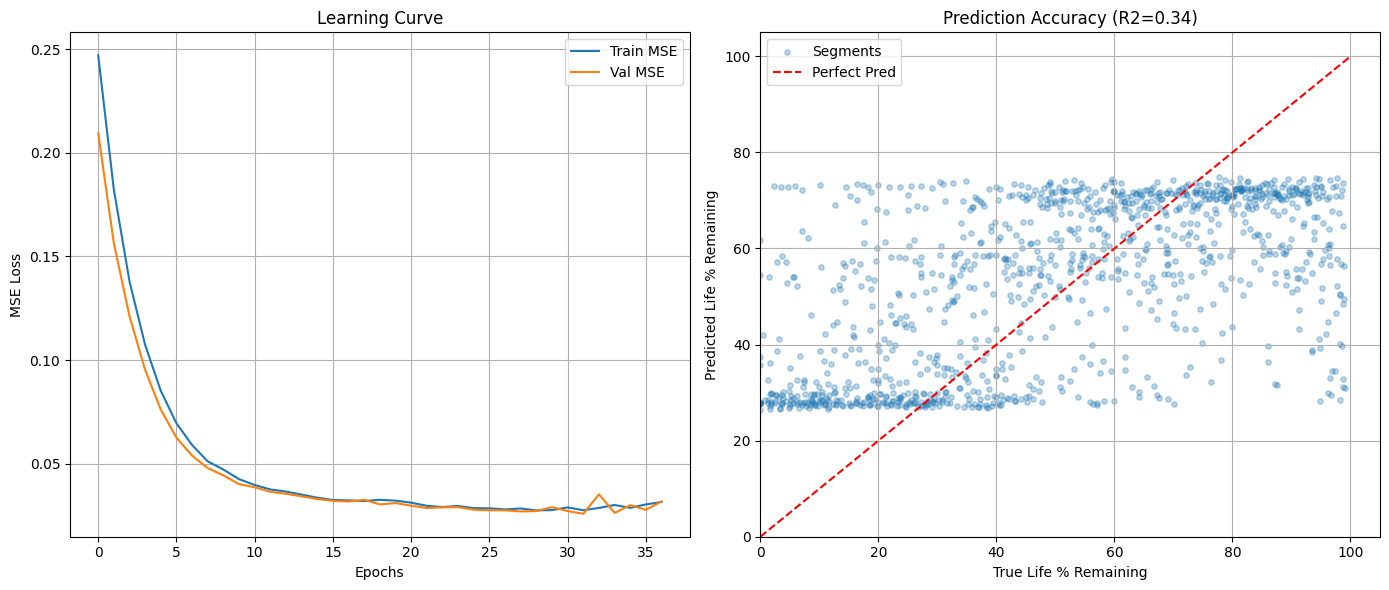

In [ ]:
evaluate_and_plot_results(model_evolved, X_test, y_test, history_evolved)

*Test Model with 3 LAYER BI-LSTM With subsampled*

In [ ]:
N = 4 

# 1. Sous-échantillonnage de X (la séquence temporelle) et de mask (le masque temporel)
X_train_subsampled = X_train[:, ::N, :] 
mask_train_subsampled = mask_train[:, ::N]

# 2. y_train ne bouge pas car il n'a qu'une seule valeur par segment (5670,)
y_train_subsampled = y_train

# Répéter pour les autres ensembles
X_val_subsampled = X_val[:, ::N, :] 
mask_val_subsampled = mask_val[:, ::N]
y_val_subsampled = y_val # Pas de sous-échantillonnage

X_test_subsampled = X_test[:, ::N, :]
mask_test_subsampled = mask_test[:, ::N]
y_test_subsampled = y_test # Pas de sous-échantillonnage

In [ ]:
# --- Tuned Hyperparameters ---
LSTM_UNITS = 256
REGULARIZER = regularizers.l2(0.0001)
INITIAL_LEARNING_RATE = 0.0001 
BATCH_SIZE = 64
mask_value = 0.0 


# --- EVOLVED 3-LAYER BI-LSTM MODEL ---
model_evolved = Sequential([
    # 1. Masking Layer
    # Skips time steps where all feature values are 'mask_value' (0.0), 
    Masking(mask_value=mask_value, input_shape=(X_train_subsampled.shape[1], X_train_subsampled.shape[2])),
    
    # 2. First Bi-LSTM Layer
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS, return_sequences=True, kernel_regularizer=REGULARIZER)
    ),
    
    Dropout(0.3),
    
    # 3. Second Bi-LSTM Layer
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS, return_sequences=True, kernel_regularizer=REGULARIZER)
    ),
    
    Dropout(0.3), 

    # 4. Third Bi-LSTM Layer (Final Recurrent Layer)
    # 'return_sequences=False' extracts only the output state of the last valid time step, 
    # collapsing the time dimension before the Dense layers.
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS // 2, return_sequences=False, kernel_regularizer=REGULARIZER)
    ),
    
    Dropout(0.2),

    # 8. Dense Layers (Feature Processing)
    Dense(128, activation='relu', kernel_regularizer=REGULARIZER),
    Dense(64, activation='relu', kernel_regularizer=REGULARIZER),
    
    # 9. Regression Output
    # Single linear output unit for predicting the continuous target (time-to-death).
    Dense(1,activation='sigmoid') 
])
    
# --- Compilation ---
# Using Adam optimizer and Huber loss, which is less sensitive to outliers than MSE.
model_evolved.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE), 
    loss=tf.keras.losses.Huber(delta=2.0), 
    metrics=['mae']
)

# Callbacks for early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

print(f"Starting training for the 3-layer Bi-LSTM model with T={X_train_subsampled.shape[1]} timesteps...")

# --- Training ---
history_evolved = model_evolved.fit(
    X_train_subsampled, y_train_subsampled,           
    validation_data=(X_val_subsampled, y_val_subsampled),
    epochs=40,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
)
print("Training of the 3-layer Bi-LSTM model completed.")

/Users/remymuhlethaler/anaconda3/envs/celegans/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Starting training for the 3-layer Bi-LSTM model with T=225 timesteps...
Epoch 1/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - loss: 0.2560 - mae: 0.1818 - val_loss: 0.2178 - val_mae: 0.1673
Epoch 2/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - loss: 0.1907 - mae: 0.1672 - val_loss: 0.1644 - val_mae: 0.1653
Epoch 3/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - loss: 0.1458 - mae: 0.1673 - val_loss: 0.1271 - val_mae: 0.1662
Epoch 4/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - loss: 0.1139 - mae: 0.1681 - val_loss: 0.0995 - val_mae: 0.1668
Epoch 5/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - loss: 0.0905 - mae: 0.1666 - val_loss: 0.0803 - val_mae: 0.1673
Epoch 6/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - loss: 0.0741 - mae: 0.1672 - val_loss: 0.0664 - val_mae: 0.1654
Epoch 7/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - loss: 0.0626 - mae: 0.1671 - val_loss: 0.0567 - val_mae: 0.1661
Epoch 8/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - loss: 0.0539 - mae: 0.1658 - val_loss: 0.0499 - val_mae:

35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 300ms/step
--- RESULTS ---
R2 Score : 0.4064
MAE      : 0.1706


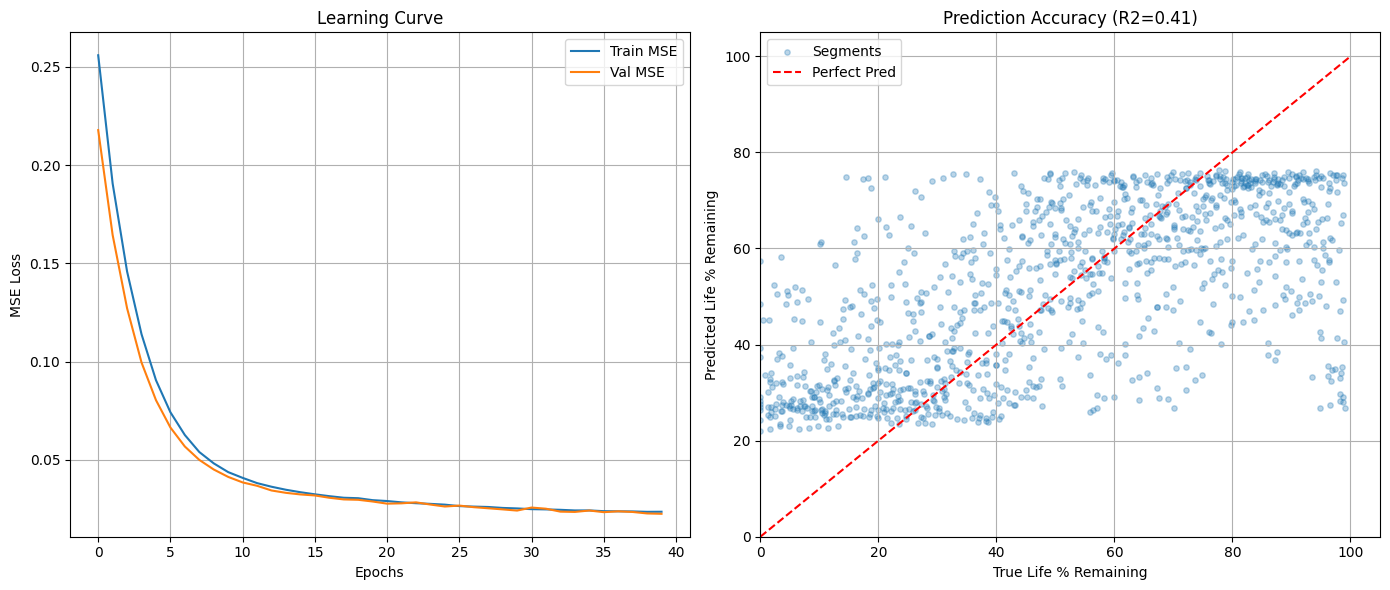

In [ ]:
evaluate_and_plot_results(model_evolved, X_test_subsampled, y_test_subsampled,history_evolved)

In [ ]:
# --- Tuned Hyperparameters ---
LSTM_UNITS = 256
REGULARIZER = regularizers.l2(0.0001)
INITIAL_LEARNING_RATE = 0.0001 
BATCH_SIZE = 64
mask_value = 0.0 


# --- EVOLVED 3-LAYER BI-LSTM MODEL ---
model_evolved = Sequential([
    # 1. Masking Layer
    # Skips time steps where all feature values are 'mask_value' (0.0), 
    Masking(mask_value=mask_value, input_shape=(X_train_subsampled.shape[1], X_train_subsampled.shape[2])),
    
    # 2. First Bi-LSTM Layer
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS, return_sequences=True, kernel_regularizer=REGULARIZER)
    ),
    
    Dropout(0.3),
    
    # 3. Second Bi-LSTM Layer
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS, return_sequences=True, kernel_regularizer=REGULARIZER)
    ),
    
    Dropout(0.3), 

    # 4. Third Bi-LSTM Layer (Final Recurrent Layer)
    # 'return_sequences=False' extracts only the output state of the last valid time step, 
    # collapsing the time dimension before the Dense layers.
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS // 2, return_sequences=False, kernel_regularizer=REGULARIZER)
    ),
    
    Dropout(0.2),

    # 8. Dense Layers (Feature Processing)
    Dense(128, activation='relu', kernel_regularizer=REGULARIZER),
    Dense(32, activation='relu', kernel_regularizer=REGULARIZER),
    
    # 9. Regression Output
    # Single linear output unit for predicting the continuous target (time-to-death).
    Dense(1,activation='sigmoid') 
])
    
# --- Compilation ---
# Using Adam optimizer and Huber loss, which is less sensitive to outliers than MSE.
model_evolved.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE), 
    loss=tf.keras.losses.Huber(delta=2.0), 
    metrics=['mae']
)

# Callbacks for early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

print(f"Starting training for the 3-layer Bi-LSTM model with T={X_train_subsampled.shape[1]} timesteps...")

# --- Training ---
history_evolved = model_evolved.fit(
    X_train_subsampled, y_train_subsampled,           
    validation_data=(X_val_subsampled, y_val_subsampled),
    epochs=30,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
)
print("Training of the 3-layer Bi-LSTM model completed.")

/Users/remymuhlethaler/anaconda3/envs/celegans/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Starting training for the 3-layer Bi-LSTM model with T=225 timesteps...
Epoch 1/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - loss: 0.2539 - mae: 0.1877 - val_loss: 0.2144 - val_mae: 0.1705
Epoch 2/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - loss: 0.1875 - mae: 0.1680 - val_loss: 0.1615 - val_mae: 0.1707
Epoch 3/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - loss: 0.1424 - mae: 0.1680 - val_loss: 0.1233 - val_mae: 0.1667
Epoch 4/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - loss: 0.1101 - mae: 0.1670 - val_loss: 0.0959 - val_mae: 0.1662
Epoch 5/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - loss: 0.0870 - mae: 0.1668 - val_loss: 0.0774 - val_mae: 0.1674
Epoch 6/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - loss: 0.0706 - mae: 0.1663 - val_loss: 0.0639 - val_mae: 0.1691
Epoch 7/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - loss: 0.0593 - mae: 0.1674 - val_loss: 0.0541 - val_mae: 0.1655
Epoch 8/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - loss: 0.0512 - mae: 0.1666 - val_loss: 0.0472 - val_mae:

35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 342ms/step
--- RESULTS ---
R2 Score : 0.3886
MAE      : 0.1722


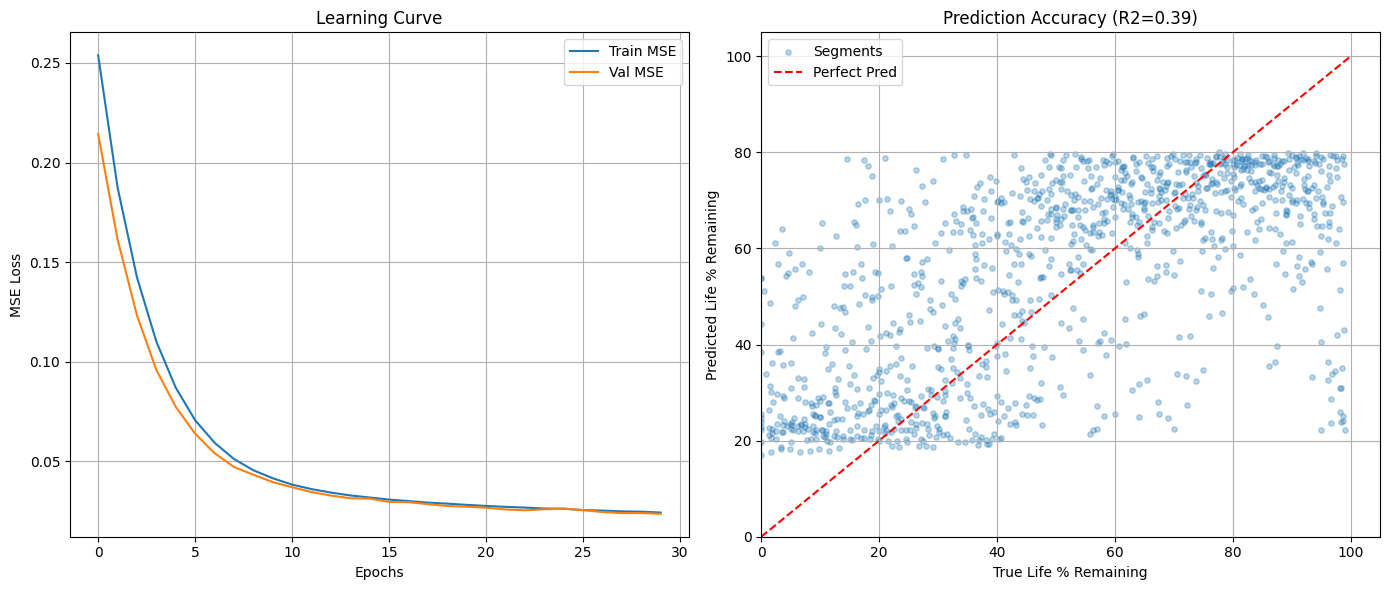

In [ ]:
evaluate_and_plot_results(model_evolved, X_test_subsampled, y_test_subsampled, history_evolved)

*Test lighter model with differents N subsampeld*

--- 🧪 Démarrage de l'expérience avec N=3 (T=300 pas de temps) ---
Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 684ms/step - loss: 0.4605 - mae: 0.1877 - val_loss: 0.3302 - val_mae: 0.1708
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 32s 708ms/step - loss: 0.2519 - mae: 0.1689 - val_loss: 0.1817 - val_mae: 0.1667
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 875ms/step - loss: 0.1407 - mae: 0.1680 - val_loss: 0.1041 - val_mae: 0.1740
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 37s 826ms/step - loss: 0.0828 - mae: 0.1684 - val_loss: 0.0638 - val_mae: 0.1729
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 37s 828ms/step - loss: 0.0530 - mae: 0.1675 - val_loss: 0.0434 - val_mae: 0.1724
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 37s 826ms/step - loss: 0.0384 - mae: 0.1680 - val_loss: 0.0336 - val_mae: 0.1704
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 38s 836ms/step - loss: 0.0315 - mae: 0.1694 - val_loss: 0.0286 - val_mae: 0.1681
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 37s 829ms/step - loss: 0.0278 - mae: 0.1684 - val_loss: 0.0254 

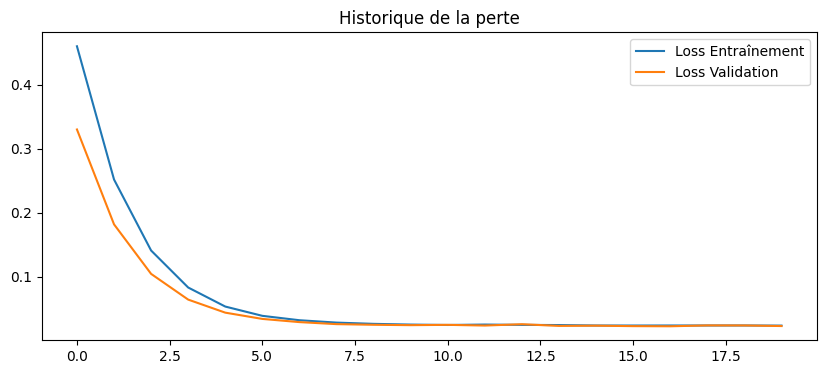

--- 🧪 Démarrage de l'expérience avec N=4 (T=225 pas de temps) ---
Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 494ms/step - loss: 0.4609 - mae: 0.1833 - val_loss: 0.3320 - val_mae: 0.1703
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 502ms/step - loss: 0.2526 - mae: 0.1677 - val_loss: 0.1831 - val_mae: 0.1684
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 28s 632ms/step - loss: 0.1411 - mae: 0.1682 - val_loss: 0.1036 - val_mae: 0.1682
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 28s 624ms/step - loss: 0.0827 - mae: 0.1682 - val_loss: 0.0632 - val_mae: 0.1669
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 28s 617ms/step - loss: 0.0531 - mae: 0.1676 - val_loss: 0.0428 - val_mae: 0.1676
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 28s 624ms/step - loss: 0.0385 - mae: 0.1682 - val_loss: 0.0329 - val_mae: 0.1676
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 28s 622ms/step - loss: 0.0310 - mae: 0.1666 - val_loss: 0.0282 - val_mae: 0.1702
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 28s 629ms/step - loss: 0.0276 - mae: 0.1676 - val_loss: 0.0270 

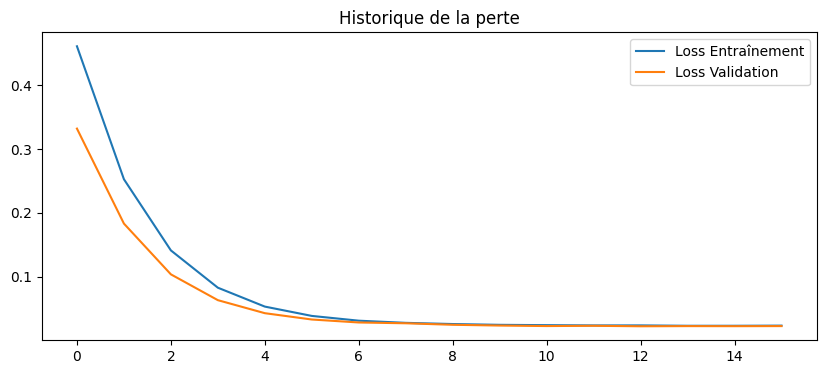

--- 🧪 Démarrage de l'expérience avec N=5 (T=180 pas de temps) ---
Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 401ms/step - loss: 0.4587 - mae: 0.1865 - val_loss: 0.3285 - val_mae: 0.1696
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 410ms/step - loss: 0.2508 - mae: 0.1697 - val_loss: 0.1808 - val_mae: 0.1664
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 510ms/step - loss: 0.1402 - mae: 0.1690 - val_loss: 0.1030 - val_mae: 0.1659
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 515ms/step - loss: 0.0825 - mae: 0.1695 - val_loss: 0.0629 - val_mae: 0.1678
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 500ms/step - loss: 0.0529 - mae: 0.1683 - val_loss: 0.0430 - val_mae: 0.1717
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 500ms/step - loss: 0.0385 - mae: 0.1683 - val_loss: 0.0328 - val_mae: 0.1667
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 503ms/step - loss: 0.0314 - mae: 0.1687 - val_loss: 0.0283 - val_mae: 0.1683
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 501ms/step - loss: 0.0278 - mae: 0.1681 - val_loss: 0.0267 

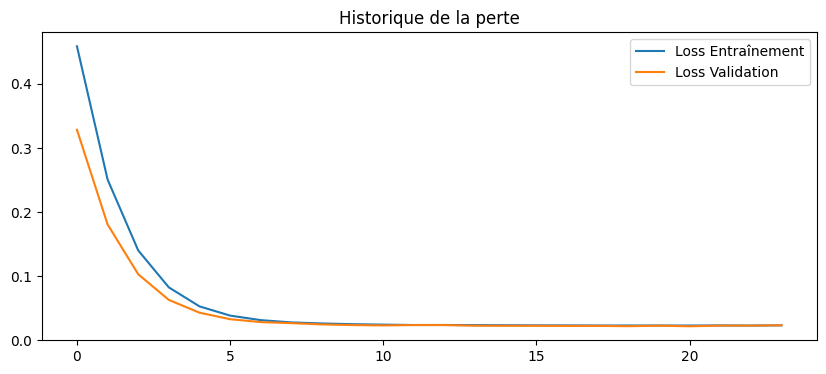

--- 🧪 Démarrage de l'expérience avec N=6 (T=150 pas de temps) ---
Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 328ms/step - loss: 0.4612 - mae: 0.1856 - val_loss: 0.3304 - val_mae: 0.1682
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 326ms/step - loss: 0.2523 - mae: 0.1675 - val_loss: 0.1822 - val_mae: 0.1678
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 433ms/step - loss: 0.1405 - mae: 0.1661 - val_loss: 0.1030 - val_mae: 0.1678
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 435ms/step - loss: 0.0820 - mae: 0.1663 - val_loss: 0.0633 - val_mae: 0.1676
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 411ms/step - loss: 0.0526 - mae: 0.1673 - val_loss: 0.0423 - val_mae: 0.1668
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 410ms/step - loss: 0.0379 - mae: 0.1665 - val_loss: 0.0329 - val_mae: 0.1662
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 417ms/step - loss: 0.0309 - mae: 0.1667 - val_loss: 0.0279 - val_mae: 0.1672
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 408ms/step - loss: 0.0274 - mae: 0.1679 - val_loss: 0.0258 

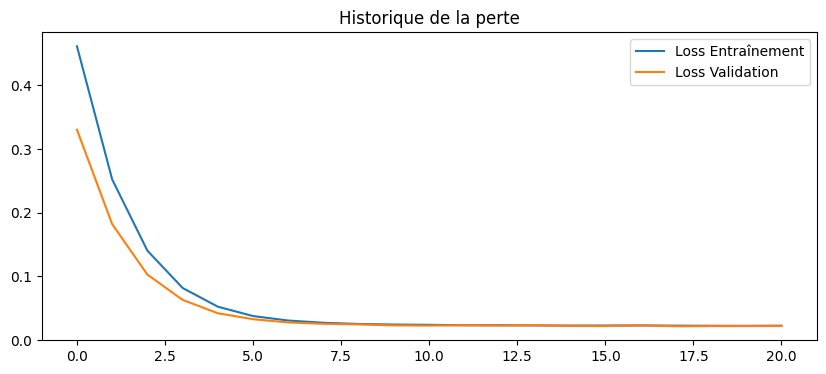


--- 📊 Synthèse des Résultats sur Modèle Léger ---
N=3: MAE = 0.1806 (Époques: 20)
N=4: MAE = 0.1786 (Époques: 16)
N=5: MAE = 0.1802 (Époques: 24)
N=6: MAE = 0.1825 (Époques: 21)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras import regularizers

# --- Hyperparamètres pour le Modèle Réduit ---
LIGHT_LSTM_UNITS = 128
LIGHT_REGULARIZER = regularizers.l2(0.001)  # Augmenté légèrement la régularisation pour le petit modèle
LIGHT_INITIAL_LEARNING_RATE = 0.0005 # Augmenté légèrement le LR initial
LIGHT_BATCH_SIZE = 128 # Doublé le batch size pour accélérer l'entraînement
LIGHT_EPOCHS = 30
LIGHT_PATIENCE = 3
mask_value = 0.0 


def evaluate_and_plot_results(model, X_test, y_test, history):
    """Placeholder pour votre fonction d'évaluation/plot"""
    # Évaluation
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nRésultats Test pour le modèle : Perte (Huber) = {loss:.4f}, MAE = {mae:.4f}")
    

    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Loss Entraînement')
    plt.plot(history.history['val_loss'], label='Loss Validation')
    plt.title('Historique de la perte')
    plt.legend()
    plt.show()
    
    return mae # Retourne le MAE pour la comparaison

def create_light_model(input_shape):
    """Définit et compile le modèle Bi-LSTM réduit."""
    
    model = Sequential([
        Masking(mask_value=mask_value, input_shape=input_shape),
        
        # 1. Première Couche Bi-LSTM
        tf.keras.layers.Bidirectional(
            LSTM(LIGHT_LSTM_UNITS, return_sequences=True, kernel_regularizer=LIGHT_REGULARIZER)
        ),
        Dropout(0.2),
        
        # 2. Dernière Couche Bi-LSTM
        tf.keras.layers.Bidirectional(
            LSTM(LIGHT_LSTM_UNITS // 2, return_sequences=False, kernel_regularizer=LIGHT_REGULARIZER)
        ),
        Dropout(0.1),

        # Couche Dense Réduite
        Dense(32, activation='relu', kernel_regularizer=LIGHT_REGULARIZER),
        
        # Sortie Régression
        Dense(1, activation='sigmoid') 
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LIGHT_INITIAL_LEARNING_RATE), 
        loss=tf.keras.losses.Huber(delta=2.0), 
        metrics=['mae']
    )
    return model


def run_subsampling_experiment(N, X_train, y_train, X_val, y_val, X_test, y_test):
    """Exécute l'expérience de sous-échantillonnage pour une valeur N donnée."""
    
    # 1. Sous-échantillonnage des données
    X_train_sub = X_train[:, ::N, :] 
    X_val_sub = X_val[:, ::N, :] 
    X_test_sub = X_test[:, ::N, :]

    # Les labels y_train, y_val, y_test ne changent pas.
    
    print(f"--- Démarrage de l'expérience avec N={N} (T={X_train_sub.shape[1]} pas de temps) ---")
    
    # 2. Création du modèle
    model = create_light_model(input_shape=(X_train_sub.shape[1], X_train_sub.shape[2]))
    
    # 3. Callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=LIGHT_PATIENCE, 
        restore_best_weights=True
    )
    
    # 4. Entraînement
    history = model.fit(
        X_train_sub, y_train,           
        validation_data=(X_val_sub, y_val),
        epochs=LIGHT_EPOCHS,
        batch_size=LIGHT_BATCH_SIZE,
        callbacks=[early_stop],
    )
    
    print(f"Entraînement N={N} terminé en {len(history.history['loss'])} époques.")
    
    # 5. Évaluation et stockage du résultat
    mae = evaluate_and_plot_results(model, X_test_sub, y_test, history)
    
    return mae, len(history.history['loss'])


# --- Exécution des Expériences ---
N_values = [3, 4, 5, 6]
results = {}



for N in N_values:
    # Utilisez vos variables X_train, X_val, etc. ici
    mae, epochs = run_subsampling_experiment(
        N, X_train, y_train, X_val, y_val, X_test, y_test
    )
    results[N] = {'MAE': mae, 'Epochs': epochs}

print("\n--- Synthèse des Résultats sur Modèle Léger ---")
for N, res in results.items():
    print(f"N={N}: MAE = {res['MAE']:.4f} (Époques: {res['Epochs']})")

*Test model use LSTM for find feature and RandomForestRegressor to train*

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras import regularizers
from sklearn.ensemble import RandomForestRegressor

# --- Hyperparameters (INCREASED LSTM UNITS) ---
LSTM_UNITS = 128  
REGULARIZER = regularizers.l2(0.0001)
mask_value = 0.0
# Using the shapes inferred from your previous code
SEQUENCE_LENGTH = 225 
N_FEATURES = 2    

# --- 1. Define the Feature Extractor Model (The Encoder) ---

def create_bi_lstm_encoder(input_shape, lstm_units, regularizer, mask_val):
    """
    Creates a Keras model to encode the sequence into a single feature vector.
    """
    inputs = Input(shape=input_shape)
    
    # 1. Masking Layer
    x = Masking(mask_value=mask_val)(inputs)
    
    # 2. First Bi-LSTM Layer (Final Recurrent Layer in this setup)
    # return_sequences=False collapses the time dimension, yielding the feature vector
    feature_vector = Bidirectional(
        LSTM(lstm_units, return_sequences=False, kernel_regularizer=regularizer)
    )(x)
    
    # Create the model: Input -> Feature Vector
    encoder = Model(inputs=inputs, outputs=feature_vector, name='BiLSTM_Feature_Extractor')
    return encoder

# Instantiate the encoder model
input_shape = (SEQUENCE_LENGTH, N_FEATURES)
encoder_model = create_bi_lstm_encoder(input_shape, LSTM_UNITS, REGULARIZER, mask_value)

# --- 2. Train the Encoder's Weights ---

# A temporary Head for training the encoder
temp_head = Sequential([
    # Input is the feature vector shape (LSTM_UNITS * 2 = 256)
    Input(shape=(LSTM_UNITS * 2,)), 
    Dropout(0.2),
    tf.keras.layers.Dense(1, activation='linear') # Single linear output for regression
], name='Temp_Regression_Head')

# Combine the Encoder and the Head into a train-ready model
training_model = Sequential([
    encoder_model,
    temp_head
])


# Compile
training_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# --- IMPORTANT ADDITION: Early Stopping Callback ---
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',         # Monitor the loss on the validation set
    patience=5,                 # Wait for 5 epochs without improvement
    restore_best_weights=True   # Use the weights from the best-performing epoch
)


print("\n--- Training the Bi-LSTM Encoder Weights (With Early Stopping) ---")
# Use validation data in the fit call
history = training_model.fit(
    X_train_subsampled, 
    y_train_subsampled, 
    validation_data=(X_val_subsampled, y_val_subsampled), # <-- IMPORTANT: Use validation data
    epochs=20, # Increased max epochs, but EarlyStopping will manage the real stopping point
    batch_size=32,
    callbacks=[early_stop] # <-- Add the callback
) 
print("Encoder training completed. Best weights are restored.")

# --- 3. Extract Features for Random Forest ---

# The encoder transforms the (Samples, Time, Features) data into (Samples, Feature_Vector_Size)
X_train_features = encoder_model.predict(X_train_subsampled)

# The shape of X_train_features should now be (Samples, 256)
print(f"\nOriginal Input Shape: {X_train_subsampled.shape}")
print(f"Extracted Features Shape: {X_train_features.shape}")

# --- 4. Train the Random Forest Regressor ---

# Instantiate the Random Forest Regressor (Hyperparameters left for later tuning)
rf_regressor = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    random_state=42,
    n_jobs=-1 
)

print("\n--- Training Random Forest Regressor on Bi-LSTM Features ---")
# Train the RF model on the extracted features and the original targets
rf_regressor.fit(X_train_features, y_train_subsampled.ravel()) 

print("Random Forest Regressor training completed.")
# print(f"RF Feature Importance (Top 5): {rf_regressor.feature_importances_[:5]}") # Use [:5] to limit output

X_test_features = encoder_model.predict(X_test_subsampled)

# 2. Predict using the Random Forest
rf_predictions = rf_regressor.predict(X_test_features)

print(f"\nTest Data (Sequential) Shape: {X_test_subsampled.shape}")
print(f"Test Features (Vector) Shape: {X_test_features.shape}")
print(f"Random Forest Predictions Sample (First 5): {rf_predictions.flatten()[:5]}")


--- Training the Bi-LSTM Encoder Weights (With Early Stopping) ---
Epoch 1/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 94s 496ms/step - loss: 0.0647 - mae: 0.1974 - val_loss: 0.0490 - val_mae: 0.1751
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 112s 630ms/step - loss: 0.0495 - mae: 0.1756 - val_loss: 0.0447 - val_mae: 0.1696
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 111s 623ms/step - loss: 0.0478 - mae: 0.1717 - val_loss: 0.0510 - val_mae: 0.1821
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 108s 607ms/step - loss: 0.0477 - mae: 0.1726 - val_loss: 0.0472 - val_mae: 0.1764
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 108s 605ms/step - loss: 0.0467 - mae: 0.1702 - val_loss: 0.0443 - val_mae: 0.1654
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 104s 583ms/step - loss: 0.0466 - mae: 0.1707 - val_loss: 0.0501 - val_mae: 0.1779
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 105s 593ms/step - loss: 0.0463 - mae: 0.1692 - val_loss: 0.0438 - val_mae: 0.1663
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 113s 635ms/step - loss: 0.0457 - mae: 0

In [25]:
# --- 1. Calculate MAE ---
# Measures the average magnitude of the errors in a set of predictions, 
# without considering their direction. It's robust to outliers.
mae = mean_absolute_error(y_test_subsampled, rf_predictions)

# --- 2. Calculate R-squared (R²) ---
# R-squared measures the proportion of the variance in the dependent 
# variable that is predictable from the independent variables.
# A value closer to 1.0 is better.
r2 = r2_score(y_test_subsampled, rf_predictions)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Mean Absolute Error (MAE): 0.1764
R-squared (R2): 0.3620


*Try augmentation data using window in segement*

In [ ]:


def prepare_X_y_and_ids(segments, coord_indices=[2,3]):
    """Extrait X, y, mask et les ID de ver pour CHAQUE segment."""
    X = np.array([seg['features'][:, coord_indices] for seg in segments])
    y = np.array([seg['y'] for seg in segments])
    mask = np.array([seg['mask'] for seg in segments])
    # **NOUVEAU : Récupération des IDs pour chaque segment**
    worm_ids_per_segment = np.array([seg['worm_id'] for seg in segments])
    return X, y, mask, worm_ids_per_segment

# Mise à jour des appels pour récupérer le 4ème élément
X_train, y_train, mask_train, worm_ids_train = prepare_X_y_and_ids(train_segments)
X_val, y_val, mask_val, worm_ids_val         = prepare_X_y_and_ids(val_segments)
X_test, y_test, mask_test, worm_ids_test     = prepare_X_y_and_ids(test_segments)

# Vous devriez maintenant voir 5670 IDs pour le train
print(f"Shapes (Features, Target, Worm IDs): {X_train.shape}, {y_train.shape}, {worm_ids_train.shape}")
print("-" * 50)


# ===========================================================
# Window builder avec chevauchement (Corrigé)
# ===========================================================

def build_windows(X_segments, y_segments, worm_ids, window=450):
    Xw = []
    yw = []
    ww = []

    for seg, y, w in zip(X_segments, y_segments, worm_ids):
        n = seg.shape[0]
        for start in range(0, n, window):
            end = start + window
            if end <= n:
                Xw.append(seg[start:end])
                yw.append(y)
                ww.append(w)

    return np.array(Xw), np.array(yw), np.array(ww)


# Appel de la fonction avec la liste des IDs par segment (nouvelle variable)
X_train_win, y_train_win, worm_train_win = build_windows(X_train, y_train, worm_ids_train)
X_val_win,   y_val_win,   worm_val_win   = build_windows(X_val,   y_val,   worm_ids_val)
X_test_win,  y_test_win,  worm_test_win  = build_windows(X_test,  y_test,  worm_ids_test)

print("Train windows (attendu : ~17010):", X_train_win.shape)
print("Val windows:  ", X_val_win.shape)
print("Test windows: ", X_test_win.shape)

print("Unique worms in train (attendu : 72):", len(np.unique(worm_train_win)))
print("Unique worms in test (attendu : 16):",  len(np.unique(worm_test_win)))

Shapes (Features, Target, Worm IDs): (5670, 900, 2), (5670,), (5670,)
--------------------------------------------------
Train windows (attendu : ~17010): (11340, 450, 2)
Val windows:   (2724, 450, 2)
Test windows:  (2236, 450, 2)
Unique worms in train (attendu : 72): 72
Unique worms in test (attendu : 16): 16


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.callbacks import EarlyStopping


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dropout, Dense
from tensorflow.keras import regularizers

# Mask padded frames
mask_value = 0.0
    
model = Sequential([
    # 1. Masking
    Masking(mask_value=mask_value, input_shape=(X_train.shape[1], X_train.shape[2])),
    
    # 2. 💥 Ajout d'une première couche LSTM plus large
    # return_sequences=True est crucial pour passer la sortie complète à la couche suivante
    LSTM(256, return_sequences=True, 
            kernel_regularizer=regularizers.l2(0.0001)),
    
    # 3.Dropout pour éviter l'overfitting entre les couches
    Dropout(0.1),
    
    # 4. 💥 Ajout d'une seconde couche LSTM
    # return_sequences=False car c'est la dernière couche récurrente
    LSTM(256, return_sequences=False, 
            kernel_regularizer=regularizers.l2(0.0001)),
    #Dropout(0.1),

    
    # 6. Couches Denses plus profondes
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    #Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    
    # 7. Sortie de régression (activation linéaire par défaut)
    Dense(1,  activation='sigmoid' ) 
])
    

#model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.compile(
        optimizer='adam', 
        loss=tf.keras.losses.Huber(delta=2.0), 
        metrics=['mae']
    )
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(
    X_train_win, y_train_win,           
    validation_data=(X_val_win, y_val_win),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)
say("Votre code est terminé")

Epoch 1/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 515s 362ms/step - loss: 0.0390 - mae: 0.2096 - val_loss: 0.0425 - val_mae: 0.2084
Epoch 2/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 530s 373ms/step - loss: 0.0327 - mae: 0.1874 - val_loss: 0.0299 - val_mae: 0.1947
Epoch 3/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 538s 380ms/step - loss: 0.0280 - mae: 0.1825 - val_loss: 0.0247 - val_mae: 0.1745
Epoch 4/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 547s 386ms/step - loss: 0.0269 - mae: 0.1814 - val_loss: 0.0244 - val_mae: 0.1759
Epoch 5/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 1690s 1s/step - loss: 0.0326 - mae: 0.2023 - val_loss: 0.0246 - val_mae: 0.1750
Epoch 6/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 637s 450ms/step - loss: 0.0262 - mae: 0.1788 - val_loss: 0.0235 - val_mae: 0.1737
Epoch 7/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 634s 447ms/step - loss: 0.0249 - mae: 0.1756 - val_loss: 0.0249 - val_mae: 0.1776
Epoch 8/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 632s 446ms/step - loss: 0.0245 - mae: 0.1741 - val_loss: 0.0226 - val_mae: 0.1694
Epoch 9/20

280/280 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step
--- RESULTATS (Global Norm - Speed/Angle Only) ---
R2 Score : 0.3967
MAE      : 0.1748


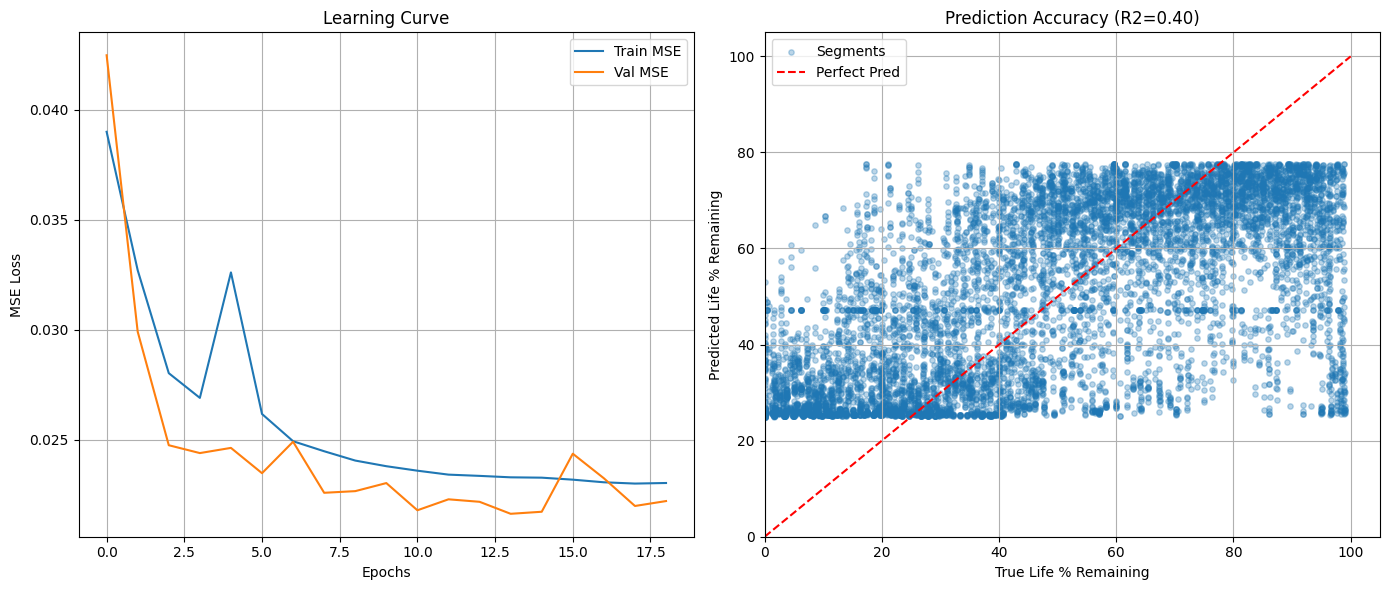

In [ ]:
evaluate_and_plot_results(model, X_test_win, y_test_win, history)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K

# --- Hyperparamètres ajustés ---
LSTM_UNITS = 128 # Réduction pour compenser l'effet bidirectionnel (capacité x2)
REGULARIZER = regularizers.l2(0.0001)
INITIAL_LEARNING_RATE = 0.0001 # Taux d'apprentissage réduit pour la stabilité
BATCH_SIZE = 32
mask_value = 0.0 # Valeur de masquage pour les séquences paddées
# -------------------------------

model_bi_lstm = Sequential([
    Masking(mask_value=0.0, input_shape=(X_train.shape[1], X_train.shape[2])), 
    
    # Single, stronger Bi-LSTM layer (returns sequences for better feature extraction)
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS, return_sequences=True, kernel_regularizer=REGULARIZER)
    ),
    
    Dropout(0.1),
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS // 2, return_sequences=False, kernel_regularizer=REGULARIZER)
    ),
    # Dense head
    Dense(64, activation='relu', kernel_regularizer=REGULARIZER),
    Dropout(0.1),
    Dense(32, activation='relu', kernel_regularizer=REGULARIZER),
    
    # 7. Sortie de Régression (Identique)
    Dense(1, activation='sigmoid') 
])
    
# --- Compilation avec Optimiseur et Taux d'Apprentissage ajustés ---
model_bi_lstm.compile(
    # Utilisation d'un taux d'apprentissage plus faible pour une convergence stable
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE), 
    #loss=tf.keras.losses.Huber(delta=1.0), # Huber Loss conservée
    loss = "mse",
    metrics=['mae']
)

# Callbacks d'arrêt précoce (Identique)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)


# --- Entraînement ---
print(f"Démarrage de l'entraînement avec BATCH_SIZE={BATCH_SIZE} et Learning Rate={INITIAL_LEARNING_RATE}...")

history = model_bi_lstm.fit(
    X_train, y_train,           
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=BATCH_SIZE, # Utilisation du nouveau batch size
    callbacks=[early_stop] 
)

print("Entraînement du modèle Bi-LSTM terminé.")
# Vous pouvez imprimer model_bi_lstm.summary() ici pour voir la nouvelle structure

/Users/remymuhlethaler/anaconda3/envs/celegans/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Démarrage de l'entraînement avec BATCH_SIZE=32 et Learning Rate=0.0001...
Epoch 1/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 172s 950ms/step - loss: 0.1108 - mae: 0.1882 - val_loss: 0.0954 - val_mae: 0.1740
Epoch 2/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - loss: 0.0913 - mae: 0.1732 - val_loss: 0.0836 - val_mae: 0.1677
Epoch 3/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - loss: 0.0813 - mae: 0.1716 - val_loss: 0.0754 - val_mae: 0.1688
Epoch 4/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - loss: 0.0748 - mae: 0.1709 - val_loss: 0.0706 - val_mae: 0.1684
Epoch 5/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - loss: 0.0707 - mae: 0.1719 - val_loss: 0.0656 - val_mae: 0.1660
Epoch 6/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - loss: 0.0670 - mae: 0.1702 - val_loss: 0.0641 - val_mae: 0.1672
Epoch 7/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - loss: 0.0648 - mae: 0.1705 - val_loss: 0.0607 - val_mae: 0.1651
Epoch 8/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - loss: 0.0624 - mae: 0.1694 - val_lo

35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step
--- RESULTATS (Global Norm - Speed/Angle Only) ---
R2 Score : 0.3443
MAE      : 0.1810


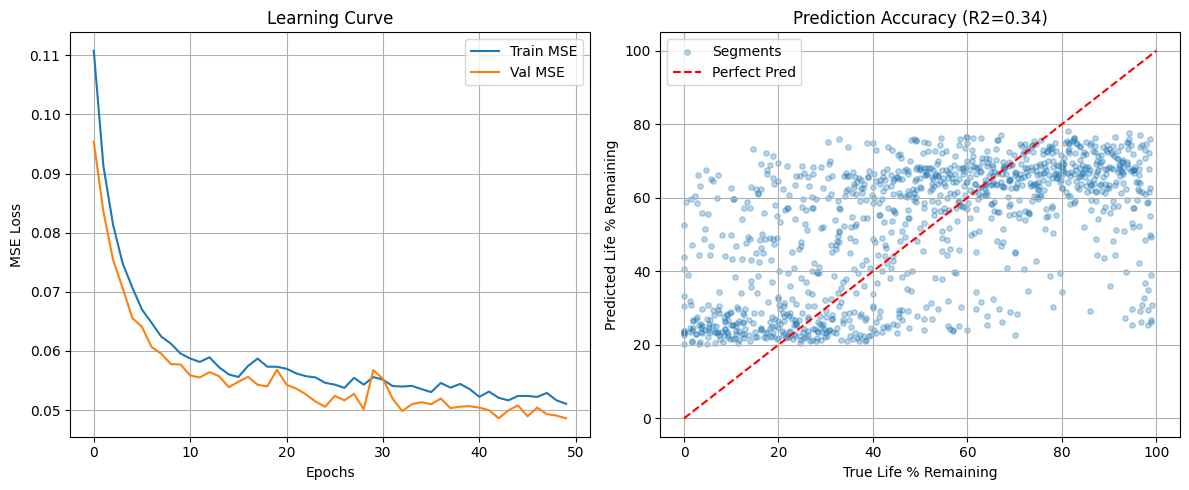

In [ ]:
import matplotlib.pyplot as plt

y_pred = model_bi_lstm.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"--- RESULTATS (Global Norm - Speed/Angle Only) ---")
print(f"R2 Score : {r2:.4f}")
print(f"MAE      : {mae:.4f}")

plt.figure(figsize=(12, 5))

# Courbe d'apprentissage
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# Scatter Plot Prédictions
plt.subplot(1, 2, 2)
plt.scatter(y_test*100, y_pred*100, alpha=0.3, s=15, label='Segments')
plt.plot([0, 100], [0, 100], 'r--', label='Perfect Pred')
plt.title(f'Prediction Accuracy (R2={r2:.2f})')
plt.xlabel('True Life % Remaining')
plt.ylabel('Predicted Life % Remaining')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
--- RESULTATS (Global Norm - Speed/Angle Only) ---
R2 Score : 0.3635
MAE      : 0.1786


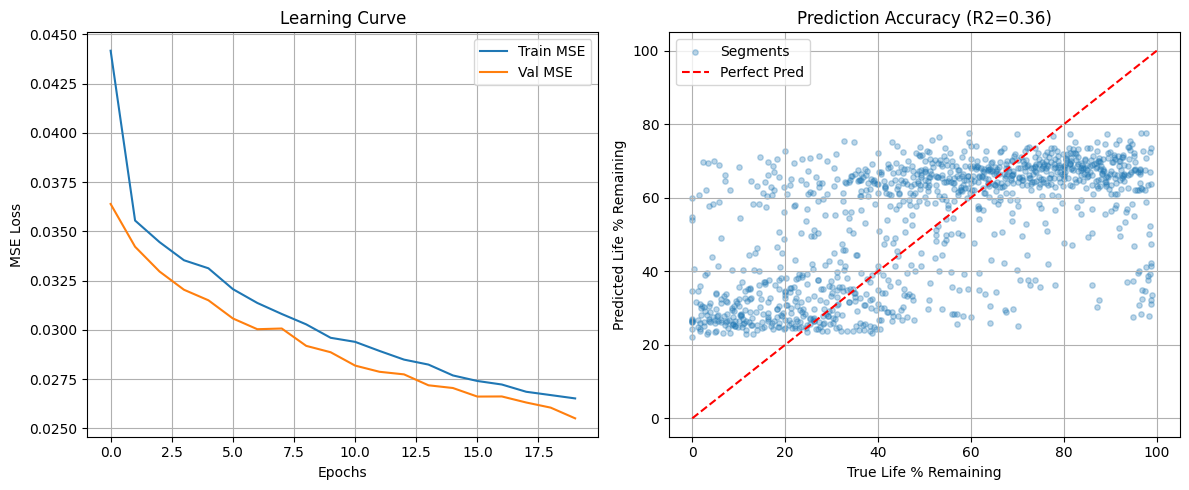

In [ ]:
import matplotlib.pyplot as plt

y_pred = model_bi_lstm.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"--- RESULTATS (Global Norm - Speed/Angle Only) ---")
print(f"R2 Score : {r2:.4f}")
print(f"MAE      : {mae:.4f}")

plt.figure(figsize=(12, 5))

# Courbe d'apprentissage
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# Scatter Plot Prédictions
plt.subplot(1, 2, 2)
plt.scatter(y_test*100, y_pred*100, alpha=0.3, s=15, label='Segments')
plt.plot([0, 100], [0, 100], 'r--', label='Perfect Pred')
plt.title(f'Prediction Accuracy (R2={r2:.2f})')
plt.xlabel('True Life % Remaining')
plt.ylabel('Predicted Life % Remaining')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras import regularizers

# --- Hyperparamètres Ajustés ---
# Note : LSTM_UNITS est resté à 32, vous pouvez l'augmenter si l'amélioration est insuffisante.
LSTM_UNITS = 256
REGULARIZER = regularizers.l2(0.0001)
INITIAL_LEARNING_RATE = 0.0001 
BATCH_SIZE = 64
mask_value = 0.0 
# Assurez-vous que X_train.shape[1] est bien la nouvelle longueur T=700

# --- MODÈLE BI-LSTM ÉVOLUÉ (3 Couches) ---
model_evolved = Sequential([
    # 1. Couche de Masquage
    Masking(mask_value=mask_value, input_shape=(X_train.shape[1], X_train.shape[2])),
    
    # 2. Première Couche Bi-LSTM (return_sequences=True)
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS, return_sequences=True, kernel_regularizer=REGULARIZER)
    ),
    
    # 3. Dropout
    Dropout(0.1),
    
    # --- NOUVEAUTÉ : Deuxième Couche Bi-LSTM (return_sequences=True) ---
    # Cette couche augmente la profondeur pour mieux capturer les dépendances longues.
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS, return_sequences=True, kernel_regularizer=REGULARIZER)
    ),
    
    # 4. Dropout
    Dropout(0.1), # Dropout supplémentaire pour éviter le surapprentissage

    # 5. Troisième Couche Bi-LSTM (return_sequences=False - la dernière)
    # On utilise une taille plus petite (la moitié) pour la dernière couche avant la partie dense.
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS // 2, return_sequences=False, kernel_regularizer=REGULARIZER)
    ),
    
    # 6. Dropout
    Dropout(0.1),

    # 7. Couches Denses (Conservées)
    Dense(64, activation='relu', kernel_regularizer=REGULARIZER),
    Dense(32, activation='relu', kernel_regularizer=REGULARIZER),
    
    # 8. Sortie de Régression
    Dense(1) 
])
    
# --- Compilation et Entraînement ---
model_evolved.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE), 
    loss=tf.keras.losses.Huber(delta=2.0), 
    metrics=['mae']
)

# Callbacks d'arrêt précoce (Conservés)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)


print(f"Démarrage de l'entraînement du modèle 3-couches avec T={X_train.shape[1]}...")

history_evolved = model_evolved.fit(
    X_train, y_train,           
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop]
)

print("Entraînement du modèle Bi-LSTM 3-couches terminé.")
# Vous pouvez afficher model_evolved.summary() ici

/Users/remymuhlethaler/anaconda3/envs/celegans/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Démarrage de l'entraînement du modèle 3-couches avec T=900...
Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 588s 7s/step - loss: 0.2800 - mae: 0.2505 - val_loss: 0.2299 - val_mae: 0.1849
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 734s 8s/step - loss: 0.2053 - mae: 0.1757 - val_loss: 0.1850 - val_mae: 0.1793
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 725s 8s/step - loss: 0.1682 - mae: 0.1739 - val_loss: 0.1533 - val_mae: 0.1817
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 729s 8s/step - loss: 0.1401 - mae: 0.1739 - val_loss: 0.1283 - val_mae: 0.1738
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 750s 8s/step - loss: 0.1192 - mae: 0.1725 - val_loss: 0.1099 - val_mae: 0.1710
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 819s 9s/step - loss: 0.1035 - mae: 0.1732 - val_loss: 0.0966 - val_mae: 0.1721
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 13887s 158s/step - loss: 0.0917 - mae: 0.1730 - val_loss: 0.0880 - val_mae: 0.1770
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 19567s 212s/step - loss: 0.0825 - mae: 0.1721 - val_loss: 0.0785 - va

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras import regularizers

# --- Hyperparamètres Ajustés ---
# Note : LSTM_UNITS est resté à 32, vous pouvez l'augmenter si l'amélioration est insuffisante.
LSTM_UNITS = 256
REGULARIZER = regularizers.l2(0.0001)
INITIAL_LEARNING_RATE = 0.0001 
BATCH_SIZE = 64
mask_value = 0.0 
# Assurez-vous que X_train.shape[1] est bien la nouvelle longueur T=700

# --- MODÈLE BI-LSTM ÉVOLUÉ (3 Couches) ---
model_evolved = Sequential([
    # 1. Couche de Masquage
    Masking(mask_value=mask_value, input_shape=(X_train.shape[1], X_train.shape[2])),
    
    # 2. Première Couche Bi-LSTM (return_sequences=True)
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS, return_sequences=True, kernel_regularizer=REGULARIZER)
    ),
    
    # 3. Dropout
    Dropout(0.2),
    
    # --- NOUVEAUTÉ : Deuxième Couche Bi-LSTM (return_sequences=True) ---
    # Cette couche augmente la profondeur pour mieux capturer les dépendances longues.
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS, return_sequences=True, kernel_regularizer=REGULARIZER)
    ),
    
    # 4. Dropout
    Dropout(0.2), # Dropout supplémentaire pour éviter le surapprentissage

    # 5. Troisième Couche Bi-LSTM (return_sequences=False - la dernière)
    # On utilise une taille plus petite (la moitié) pour la dernière couche avant la partie dense.
    tf.keras.layers.Bidirectional(
        LSTM(LSTM_UNITS // 2, return_sequences=False, kernel_regularizer=REGULARIZER)
    ),
    
    # 6. Dropout
    Dropout(0.1),

    # 7. Couches Denses (Conservées)
    Dense(64, activation='relu', kernel_regularizer=REGULARIZER),
    Dense(32, activation='relu', kernel_regularizer=REGULARIZER),
    
    # 8. Sortie de Régression
    Dense(1) 
])
    
# --- Compilation et Entraînement ---
model_evolved.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE), 
    loss=tf.keras.losses.Huber(delta=2.0), 
    metrics=['mae']
)

# Callbacks d'arrêt précoce (Conservés)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

print(f"Démarrage de l'entraînement du modèle 3-couches avec T={X_train.shape[1]}...")

history_evolved = model_evolved.fit(
    X_train, y_train,           
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop]
)

print("Entraînement du modèle Bi-LSTM 3-couches terminé.")
# Vous pouvez afficher model_evolved.summary() ici

/Users/remymuhlethaler/anaconda3/envs/celegans/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Démarrage de l'entraînement du modèle 3-couches avec T=700...
Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 617s 7s/step - loss: 0.2939 - mae: 0.2811 - val_loss: 0.2270 - val_mae: 0.1811
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1026s 12s/step - loss: 0.2054 - mae: 0.1785 - val_loss: 0.1848 - val_mae: 0.1771
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1042s 12s/step - loss: 0.1692 - mae: 0.1796 - val_loss: 0.1531 - val_mae: 0.1757
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 968s 11s/step - loss: 0.1411 - mae: 0.1762 - val_loss: 0.1292 - val_mae: 0.1759
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 923s 10s/step - loss: 0.1198 - mae: 0.1745 - val_loss: 0.1115 - val_mae: 0.1788
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 854s 10s/step - loss: 0.1043 - mae: 0.1751 - val_loss: 0.0975 - val_mae: 0.1755
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1016s 11s/step - loss: 0.0927 - mae: 0.1762 - val_loss: 0.0871 - val_mae: 0.1735
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1014s 11s/step - loss: 0.0838 - mae: 0.1753 - val_loss: 0.0799 -

35/35 ━━━━━━━━━━━━━━━━━━━━ 34s 959ms/step
--- RESULTATS (Global Norm - Speed/Angle Only) ---
R2 Score : 0.4349
MAE      : 0.1683


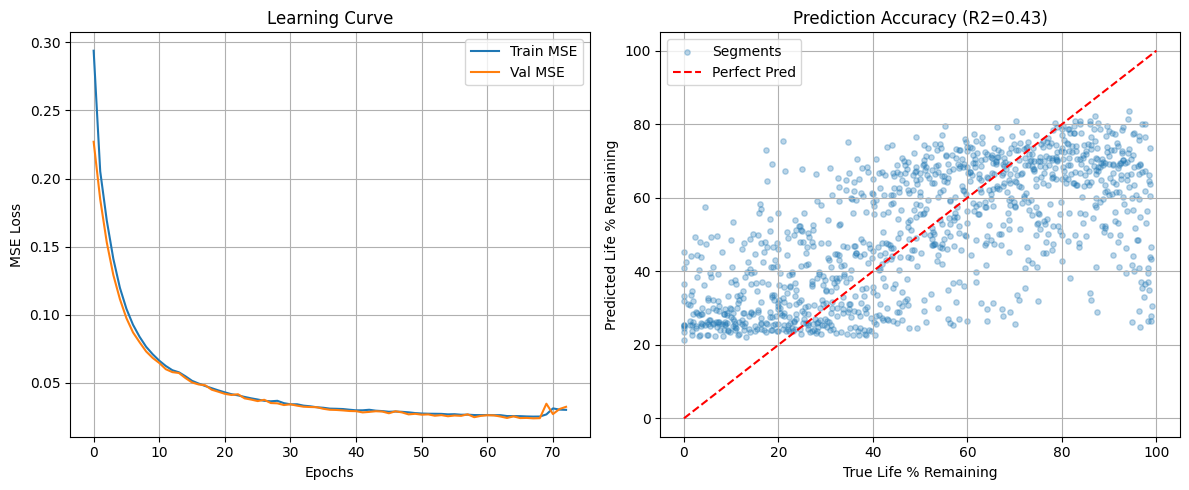

In [ ]:
import matplotlib.pyplot as plt

y_pred = model_evolved.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"--- RESULTATS (Global Norm - Speed/Angle Only) ---")
print(f"R2 Score : {r2:.4f}")
print(f"MAE      : {mae:.4f}")

plt.figure(figsize=(12, 5))

# Courbe d'apprentissage
plt.subplot(1, 2, 1)
plt.plot(history_evolved.history['loss'], label='Train MSE')
plt.plot(history_evolved.history['val_loss'], label='Val MSE')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# Scatter Plot Prédictions
plt.subplot(1, 2, 2)
plt.scatter(y_test*100, y_pred*100, alpha=0.3, s=15, label='Segments')
plt.plot([0, 100], [0, 100], 'r--', label='Perfect Pred')
plt.title(f'Prediction Accuracy (R2={r2:.2f})')
plt.xlabel('True Life % Remaining')
plt.ylabel('Predicted Life % Remaining')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras import regularizers

# --- Hyperparamètres Ajustés ---
# Note : LSTM_UNITS est resté à 32, vous pouvez l'augmenter si l'amélioration est insuffisante.
LSTM_UNITS = 512
REGULARIZER = regularizers.l2(0.0001)
INITIAL_LEARNING_RATE = 0.0001 
BATCH_SIZE = 64
mask_value = 0.0 
# Assurez-vous que X_train.shape[1] est bien la nouvelle longueur T=700

# --- MODÈLE BI-LSTM ÉVOLUÉ (3 Couches) ---
model_evolved = Sequential([
    # 1. Couche de Masquage
    Masking(mask_value=mask_value, input_shape=(X_train.shape[1], X_train.shape[2])),
    
    # 2. Première Couche Bi-LSTM (return_sequences=True)
    tf.keras.layers.Bidirectional(
        LSTM(384, return_sequences=True, kernel_regularizer=REGULARIZER)
    ),
    
    # 3. Dropout
    Dropout(0.2),
    
    # --- NOUVEAUTÉ : Deuxième Couche Bi-LSTM (return_sequences=True) ---
    # Cette couche augmente la profondeur pour mieux capturer les dépendances longues.
    tf.keras.layers.Bidirectional(
        LSTM(256, return_sequences=True, kernel_regularizer=REGULARIZER)
    ),
    
    # 4. Dropout
    Dropout(0.2), # Dropout supplémentaire pour éviter le surapprentissage

    # 5. Troisième Couche Bi-LSTM (return_sequences=False - la dernière)
    # On utilise une taille plus petite (la moitié) pour la dernière couche avant la partie dense.
    tf.keras.layers.Bidirectional(
        LSTM(128, return_sequences=False, kernel_regularizer=REGULARIZER)
    ),
    
    # 6. Dropout
    Dropout(0.1),

    # 7. Couches Denses (Conservées)
    Dense(64, activation='relu', kernel_regularizer=REGULARIZER),
    Dense(32, activation='relu', kernel_regularizer=REGULARIZER),
    
    # 8. Sortie de Régression
    Dense(1) 
])
    
# --- Compilation et Entraînement ---
model_evolved.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE), 
    loss=tf.keras.losses.Huber(delta=1.0), 
    metrics=['mae']
)

# Callbacks d'arrêt précoce (Conservés)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

print(f"Démarrage de l'entraînement du modèle 3-couches avec T={X_train.shape[1]}...")

history_evolved = model_evolved.fit(
    X_train, y_train,           
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop]
)

print("Entraînement du modèle Bi-LSTM 3-couches terminé.")
# Vous pouvez afficher model_evolved.summary() ici

Démarrage de l'entraînement du modèle 3-couches avec T=900...
Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 952s 11s/step - loss: 0.3133 - mae: 0.2508 - val_loss: 0.2573 - val_mae: 0.1874
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 999s 11s/step - loss: 0.2296 - mae: 0.1774 - val_loss: 0.2049 - val_mae: 0.1766
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1060s 12s/step - loss: 0.1866 - mae: 0.1764 - val_loss: 0.1678 - val_mae: 0.1756
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1053s 12s/step - loss: 0.1543 - mae: 0.1747 - val_loss: 0.1415 - val_mae: 0.1763
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1110s 12s/step - loss: 0.1305 - mae: 0.1731 - val_loss: 0.1208 - val_mae: 0.1782
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1086s 12s/step - loss: 0.1131 - mae: 0.1728 - val_loss: 0.1054 - val_mae: 0.1768
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 986s 11s/step - loss: 0.0999 - mae: 0.1722 - val_loss: 0.0939 - val_mae: 0.1712
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1036s 12s/step - loss: 0.0899 - mae: 0.1718 - val_loss: 0.0859

In [ ]:
evaluate_and_plot_results(model_evolved, X_test, y_test, history_evolved)

NameError: name 'evaluate_and_plot_results' is not defined

Baseline loss (val): 0.024632465094327927

Testing window size = 10 (positions: 70)


100%|██████████| 70/70 [02:54<00:00,  2.49s/it]



Testing window size = 20 (positions: 69)


100%|██████████| 69/69 [02:51<00:00,  2.49s/it]



Testing window size = 50 (positions: 66)


100%|██████████| 66/66 [02:44<00:00,  2.49s/it]



Testing window size = 100 (positions: 61)


100%|██████████| 61/61 [02:30<00:00,  2.47s/it]



Testing window size = 200 (positions: 51)


100%|██████████| 51/51 [02:07<00:00,  2.50s/it]



Testing window size = 450 (positions: 26)


100%|██████████| 26/26 [01:04<00:00,  2.49s/it]


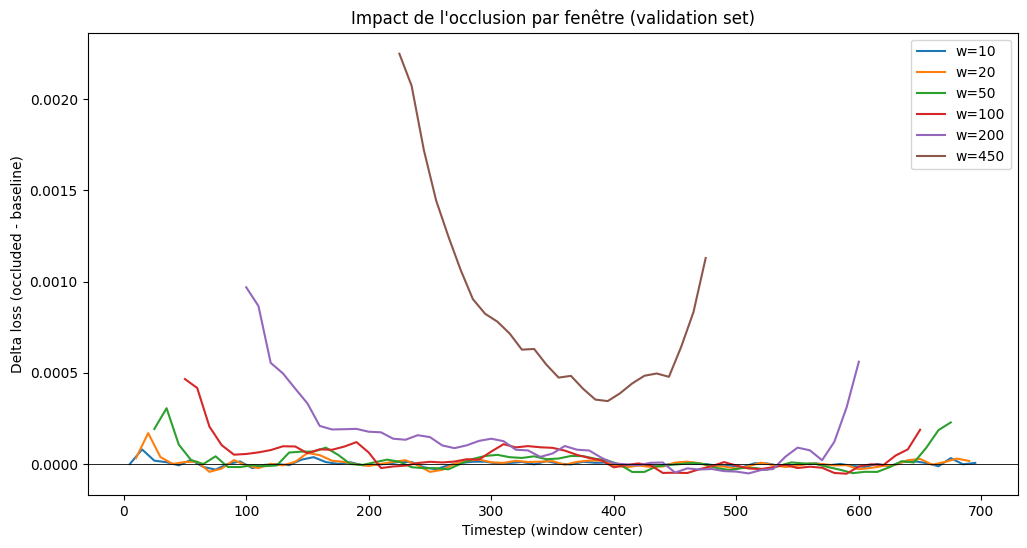

In [ ]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

# paramètres (à ajuster)
mask_value = 0.0
window_sizes = [10, 20, 50, 100, 200, 450]   # tailles de fenêtres à tester
stride = 10                                   # pas de glissement (pour accélérer)
batch_size_eval = 32

# fonction pour évaluer loss Huber sur un dataset numpy (utilise model.evaluate)
def evaluate_loss(model, X, y, batch_size=256):
    # model.evaluate returns [loss, mae] si compilé comme toi
    return model.evaluate(X, y, batch_size=batch_size, verbose=0)[0]

# baseline (sans occlusion)
baseline_loss = evaluate_loss(model_evolved, X_val, y_val, batch_size=batch_size_eval)
print("Baseline loss (val):", baseline_loss)

# dictionnaire pour stocker résultats
results = {}

for w in window_sizes:
    deltas = []
    positions = list(range(0, X_val.shape[1] - w + 1, stride))
    print(f"\nTesting window size = {w} (positions: {len(positions)})")
    # pour chaque position, on masque la fenêtre [p : p+w)
    for p in tqdm(positions):
        X_pert = X_val.copy()  # copie (attention mémoire si X_val grand)
        X_pert[:, p:p+w, :] = mask_value  # occlusion
        loss_pert = evaluate_loss(model_bi_lstm, X_pert, y_val, batch_size=batch_size_eval)
        delta = loss_pert - baseline_loss
        deltas.append(delta)
    # convertir en array et stocker
    results[w] = {
        'positions': positions,
        'deltas': np.array(deltas),
        'mean_delta': np.mean(deltas),
        'max_delta': np.max(deltas),
    }

# Visualisation : heatmap-like (une courbe par taille de fenêtre)
plt.figure(figsize=(12, 6))
for w in window_sizes:
    pos = np.array(results[w]['positions'])
    deltas = results[w]['deltas']
    plt.plot(pos + w//2, deltas, label=f"w={w}")  # plot centered at window center
plt.axhline(0, color='k', linewidth=0.6)
plt.xlabel("Timestep (window center)")
plt.ylabel("Delta loss (occluded - baseline)")
plt.title("Impact de l'occlusion par fenêtre (validation set)")
plt.legend()
plt.show()


--- ANALYSE DE LA FIABILITÉ TEMPORELLE ---
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


/var/folders/2q/767907jx6kq83xs9_kns7jsc0000gn/T/ipykernel_50407/748822531.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_age = df_time.groupby('Age_Bin')['Error'].mean().reset_index()


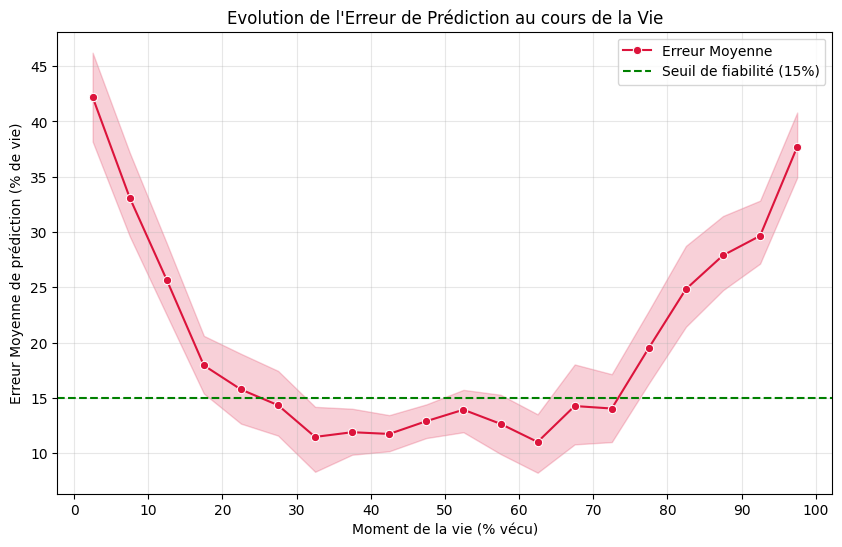


--- REPONSE ---
✅ Tu peux prédire la mort de façon fiable (erreur < 15.0%)
   à partir de 28% de la vie du ver.
   -> C'est NORMAL. Il faut attendre le milieu de vie (âge adulte) pour savoir.


In [ ]:
import pandas as pd
import seaborn as sns

# ==========================================
# 9. ANALYSE : "A QUEL MOMENT SAIT-ON ?"
# ==========================================

print("\n--- ANALYSE DE LA FIABILITÉ TEMPORELLE ---")

# 1. Préparation des données
y_pred = model.predict(X_test_f).flatten()
y_true = y_test_f  # C'est le % de vie RESTANT

# On convertit "Vie Restante" en "Âge Actuel" (Life Accomplished)
# Si y_true = 90% (il reste 90%), alors Age = 10%
current_age_pct = 100.0 - y_true

# On calcule l'erreur absolue pour chaque segment
abs_error = np.abs(y_true - y_pred)

df_time = pd.DataFrame({
    'Age_Pct': current_age_pct,
    'Error': abs_error
})

# 2. Binning (On découpe la vie en tranches de 5%)
# np.arange(0, 105, 5) crée [0, 5, ..., 100] -> 21 bords -> 20 intervalles
bins = np.arange(0, 105, 5)

# np.arange(2.5, 102.5, 5) crée [2.5, 7.5, ..., 97.5] -> 20 points centraux
labels = np.arange(2.5, 102.5, 5)

# CORRECTION : On retire le [:-1] car les tailles correspondent déjà parfaitement
# On ajoute include_lowest=True pour ne pas perdre les segments à exactement 0%
df_time['Age_Bin'] = pd.cut(df_time['Age_Pct'], bins=bins, labels=labels, include_lowest=True)

# 3. Calcul de la moyenne par tranche
error_by_age = df_time.groupby('Age_Bin')['Error'].mean().reset_index()

# ==========================================
# 10. VISUALISATION
# ==========================================
plt.figure(figsize=(10, 6))

# On trace la ligne d'erreur
sns.lineplot(data=df_time, x='Age_Bin', y='Error', marker='o', color='crimson', label='Erreur Moyenne')

# On ajoute une zone de "Tolérance acceptable" (ex: 15% d'erreur)
plt.axhline(y=15, color='green', linestyle='--', label='Seuil de fiabilité (15%)')

plt.title("Evolution de l'Erreur de Prédiction au cours de la Vie")
plt.xlabel("Moment de la vie (% vécu)")
plt.ylabel("Erreur Moyenne de prédiction (% de vie)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(np.arange(0, 105, 10)) # Graduation tous les 10%

plt.show()

# ==========================================
# 11. REPONSE AUTOMATIQUE A TA QUESTION
# ==========================================
# On cherche le PREMIER bin où l'erreur passe durablement sous les 15%
threshold = 15.0 # Tu peux changer ce seuil (ex: 10% pour être très strict)
reliable_point = None

# On parcourt les tranches d'âge
for index, row in error_by_age.iterrows():
    if row['Error'] <= threshold:
        reliable_point = row['Age_Bin']
        break

print("\n--- REPONSE ---")
if reliable_point is not None:
    print(f"✅ Tu peux prédire la mort de façon fiable (erreur < {threshold}%)")
    print(f"   à partir de {reliable_point:.0f}% de la vie du ver.")
    
    if reliable_point < 20:
        print("   -> C'est EXCELLENT. Ton modèle détecte le destin du ver dès sa jeunesse.")
    elif reliable_point < 60:
        print("   -> C'est NORMAL. Il faut attendre le milieu de vie (âge adulte) pour savoir.")
    else:
        print("   -> C'est TARDIF. On ne sait que quand le ver est déjà vieux.")
else:
    print(f"❌ Le modèle ne passe jamais sous la barre des {threshold}% d'erreur moyenne.")